<a href="https://www.kaggle.com/code/sharabhojha/chord-generation-lstm-example?scriptVersionId=225870894" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import re
import pandas as pd
###!pip install liac-arff

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Preprocessing steps:
# 1: condense onset files to just onset times and onset notes
"""
import re
import pandas as pd
import arff

# Directory path to your annotations folder
annotations_dir = "/kaggle/input/aam-annotations/AAM-annotations/"
num = 0

# Iterate through all files in the directory
for filename in os.listdir(annotations_dir):
    if "onsets" in filename and filename.endswith(".arff"):  # Ensure it's an ARFF file with 'onsets' in its name
        num += 1
        file_path = os.path.join(annotations_dir, filename)
        
        # Read the ARFF file
        def read_arff(file_path):
            with open(file_path, 'r') as f:
                arff_data = arff.load(f)
            return pd.DataFrame(arff_data['data'], columns=[attr[0] for attr in arff_data['attributes']])
        
        # Use this function instead of manual parsing
        df = read_arff(file_path)

        # Convert numeric columns where possible
        for col in df.columns:
            try:
                df[col] = pd.to_numeric(df[col])  # Convert if possible
            except ValueError:
                pass  # Keep as string if conversion fails

        all_onsets = []

        # Vectorized operation to collect all onset events
        df.drop(columns=["Onset events of Drums"], inplace=True)
        onset_columns = df.columns[df.apply(lambda col: col.astype(str).str.contains(r"\[", regex=True)).any()]
        df["Onset events"] = df[onset_columns].apply(lambda row: [int(x) for x in re.findall(r'\d+', ''.join(row.astype(str)))], axis=1)
        df.drop(onset_columns, axis=1, inplace=True)

        # Save the processed DataFrame to a new CSV file
        output_file = re.search("(\d+)", filename).group(0) + "_onset_condensed.csv"
        df.to_csv(output_file, index=False)

        if num % 100 == 0:
            print(f"Processed {filename} and saved to {output_file}")"""

'\nimport re\nimport pandas as pd\nimport arff\n\n# Directory path to your annotations folder\nannotations_dir = "/kaggle/input/aam-annotations/AAM-annotations/"\nnum = 0\n\n# Iterate through all files in the directory\nfor filename in os.listdir(annotations_dir):\n    if "onsets" in filename and filename.endswith(".arff"):  # Ensure it\'s an ARFF file with \'onsets\' in its name\n        num += 1\n        file_path = os.path.join(annotations_dir, filename)\n        \n        # Read the ARFF file\n        def read_arff(file_path):\n            with open(file_path, \'r\') as f:\n                arff_data = arff.load(f)\n            return pd.DataFrame(arff_data[\'data\'], columns=[attr[0] for attr in arff_data[\'attributes\']])\n        \n        # Use this function instead of manual parsing\n        df = read_arff(file_path)\n\n        # Convert numeric columns where possible\n        for col in df.columns:\n            try:\n                df[col] = pd.to_numeric(df[col])  # Convert 

In [3]:
# 2: encode chord names and replace said chord names with encodings in beatinfo files

chord_encodings = {0: 'A#maj', 1: 'A#min', 2: 'Amaj', 3: 'Amin', 4: 'Bmaj', 5: 'Bmin', 6: 'C#maj', 7: 'C#min', 
                   8: 'Cmaj', 9: 'Cmin', 10: 'D#maj', 11: 'D#min', 12: 'Dmaj', 13: 'Dmin', 14: 'Emaj', 15: 'Emin', 
                   16: 'F#maj', 17: 'F#min', 18: 'Fmaj', 19: 'Fmin', 20: 'G#maj', 21: 'G#min', 22: 'Gmaj', 
                   23: 'Gmin', 24: 'N.C.'}

inverted_encodings = {'A#maj': 0, 'A#min': 1, 'Amaj': 2, 'Amin': 3, 'Bmaj': 4, 'Bmin': 5, 'C#maj': 6, 'C#min': 7, 
                   'Cmaj': 8, 'Cmin': 9, 'D#maj': 10, 'D#min': 11, 'Dmaj': 12, 'Dmin': 13, 'Emaj': 14, 'Emin': 15, 
                   'F#maj': 16, 'F#min': 17, 'Fmaj': 18, 'Fmin': 19, 'G#maj': 20, 'G#min': 21, 'Gmaj': 22, 
                   'Gmin': 23, 'N.C.': 24}

"""
# Directory path to your annotations folder
headers = ['Start time in seconds', 'Bar count', 'Quarter count', 'Chord name']

# Iterate through all files in the directory
for filename in os.listdir(annotations_dir):
    if "beatinfo" in filename and filename.endswith(".arff"):  # Ensure it's an ARFF file with 'beatinfo' in its name
        file_path = os.path.join(annotations_dir, filename)
        df = pd.read_csv(file_path, comment='@', header=None)
        df.columns = headers

        for i in range(df.index.size):
            df.iat[i, 3] = df.iat[i, 3].replace("'", "")
            if df.iat[i, 3] == "BASS_NOTE_EXCEPTION":
                df.iat[i, 3] = "N.C."
            df.iat[i, 3] = inverted_encodings[df.iat[i, 3]]
    
        df.to_csv(filename.replace('arff', 'csv'), index=False)"""

'\n# Directory path to your annotations folder\nheaders = [\'Start time in seconds\', \'Bar count\', \'Quarter count\', \'Chord name\']\n\n# Iterate through all files in the directory\nfor filename in os.listdir(annotations_dir):\n    if "beatinfo" in filename and filename.endswith(".arff"):  # Ensure it\'s an ARFF file with \'beatinfo\' in its name\n        file_path = os.path.join(annotations_dir, filename)\n        df = pd.read_csv(file_path, comment=\'@\', header=None)\n        df.columns = headers\n\n        for i in range(df.index.size):\n            df.iat[i, 3] = df.iat[i, 3].replace("\'", "")\n            if df.iat[i, 3] == "BASS_NOTE_EXCEPTION":\n                df.iat[i, 3] = "N.C."\n            df.iat[i, 3] = inverted_encodings[df.iat[i, 3]]\n    \n        df.to_csv(filename.replace(\'arff\', \'csv\'), index=False)'

In [4]:
# visualize the files

###working_dir = "/kaggle/working/"
working_dir = "/kaggle/input/aam-paired-chord-onset-dataset/"
onsets = pd.read_csv(working_dir + "0001_onset_condensed.csv")
print(onsets.head())
beatinfo = pd.read_csv(working_dir + "0001_beatinfo.csv")
print(beatinfo.head())

def align_onsets_with_chords(onsets, beatinfo):
    aligned_data = []
    for _, onset_row in onsets.iterrows():
        onset_time = onset_row['Onset time in seconds']
        # Find the chord corresponding to this onset time
        chord_row = beatinfo[beatinfo['Start time in seconds'] <= onset_time].iloc[-1]
        onset_list = eval(onset_row['Onset events'])
        if chord_row['Chord name'] != 24 and len(onset_list) > 0:
            aligned_data.append((onset_list, chord_row['Chord name']))
    return aligned_data

   Onset time in seconds  Onset events
0               0.000000  [41, 60, 65]
1               0.326086      [41, 60]
2               0.652173  [41, 65, 65]
3               0.978259  [41, 65, 69]
4               1.304346  [41, 65, 65]
   Start time in seconds  Bar count  Quarter count  Chord name
0               0.000000          1              1          18
1               0.652174          1              2          18
2               1.304348          1              3          18
3               1.956522          1              4          18
4               2.608696          2              1           0


In [5]:
# create aligned data for every onset and beatinfo file

all_data = []
i = 0

while i < 100:
    i += 1
    onset_path = os.path.join(working_dir, f"{i :04d}_onset_condensed.csv")
    beatinfo_path = os.path.join(working_dir, f"{i :04d}_beatinfo.csv")
    onsets = pd.read_csv(onset_path)
    beatinfo = pd.read_csv(beatinfo_path)
    all_data.append(align_onsets_with_chords(onsets, beatinfo))

print(all_data[0:1])
#print(all_data[0:20])

[[([41, 60, 65], 18.0), ([41, 60], 18.0), ([41, 65, 65], 18.0), ([41, 65, 69], 18.0), ([41, 65, 65], 18.0), ([41, 65, 69], 18.0), ([41, 64, 60], 18.0), ([41, 64, 65], 18.0), ([46, 67, 70], 18.0), ([46, 67, 65], 0.0), ([46, 67, 70], 0.0), ([46, 69, 62], 0.0), ([46, 60, 70], 0.0), ([46, 62], 0.0), ([46, 65, 65], 0.0), ([46, 65, 70], 0.0), ([45, 69, 69], 0.0), ([45, 64, 64], 3.0), ([45, 65, 69], 3.0), ([45, 69, 60], 3.0), ([38, 69, 62], 3.0), ([38, 65, 69], 13.0), ([38, 60, 62], 13.0), ([38, 65], 13.0), ([38, 60, 62], 13.0), ([38, 60, 69], 13.0), ([38, 65, 62], 13.0), ([38, 65, 65], 13.0), ([38, 65, 62], 13.0), ([38, 65, 65], 13.0), ([38, 64, 69], 13.0), ([38, 62], 13.0), ([36, 67, 60], 13.0), ([36, 67], 8.0), ([36, 67, 60], 8.0), ([36, 69, 64], 8.0), ([36, 69, 60], 8.0), ([36, 65, 64], 8.0), ([36, 62, 67], 8.0), ([36, 62, 60], 8.0), ([41, 65, 65], 8.0), ([41, 65, 60], 18.0), ([41, 65, 65], 18.0), ([41, 65, 69], 18.0), ([41, 65], 18.0), ([41, 69], 18.0), ([41, 60], 18.0), ([41, 65], 18.0)

In [6]:
# Implement an LSTM

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, TimeDistributed, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

def create_chord_classification_model(vocab_size, embedding_dim, lstm_units, num_classes, max_sequence_length):
    # Input for note sequences
    note_input = Input(shape=(max_sequence_length,))
    
    # Embedding layer for note sequences
    note_embedding = Embedding(vocab_size, embedding_dim)(note_input)
    
    # LSTM layers
    lstm_output = LSTM(lstm_units, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(note_embedding) # with more lstm layers, return sequences = true
    lstm_output = BatchNormalization()(lstm_output)
    lstm_output = LSTM(lstm_units, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)(lstm_output)
    
    # Output layer
    output = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01))(lstm_output)
    
    model = Model(inputs=note_input, outputs=output)
    return model

# Hyperparameters
vocab_size = 128  # Assuming MIDI note range
embedding_dim = 64
lstm_units = 64
num_classes = 24  # Number of chord classes
max_sequence_length = 16  # Adjust based on your data

# Create the model
model = create_chord_classification_model(vocab_size, embedding_dim, lstm_units, num_classes, max_sequence_length)

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Split at the song level (here I can decide how many of the songs I want to use)
train_songs, test_songs = train_test_split(all_data[0:100], test_size=0.2, random_state=42)

# Flatten sequences within each split
train_data = [pair for song in train_songs for pair in song]  # Keep full song sequences together
test_data = [pair for song in test_songs for pair in song]

print(f"Total training sequences: {len(train_data)}")
print(f"Total testing sequences: {len(test_data)}")

# Function to prepare data
def prepare_data(data, max_sequence_length):
    X, y = [], []
    for notes, chord in data:
        padded_notes = tf.keras.preprocessing.sequence.pad_sequences([notes], maxlen=max_sequence_length, padding='post', truncating='post')[0]
        X.append(padded_notes)
        y.append(chord)
    return np.array(X), np.array(y)

# Prepare train and test data
X_train, y_train = prepare_data(train_data, max_sequence_length)
X_test, y_test = prepare_data(test_data, max_sequence_length)

# Convert y to one-hot encoding
y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_save = ModelCheckpoint('checkpoint.model.keras', save_best_only=True, monitor='val_accuracy', mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

history = model.fit(X_train, y_train_onehot, validation_data=(X_test, y_test_onehot), epochs=100, batch_size=32, callbacks=[early_stopping])

model.save('BestChordPredictor.keras')

# Function for inference
def predict_chord(model, note_sequence):
    padded_sequence = tf.keras.preprocessing.sequence.pad_sequences([note_sequence], maxlen=max_sequence_length, padding='post', truncating='post')
    predictions = model.predict(padded_sequence)
    return np.argmax(predictions[0])  # Return the prediction

# Example usage
sample_sequence = [60, 64, 67, 72]  # C major chor
predicted_chord = predict_chord(model, sample_sequence)
print(f"Predicted chord num: {predicted_chord}")
print(f"Predicted chord: {chord_encodings[predicted_chord]}")

Total training sequences: 45758
Total testing sequences: 10549
Epoch 1/100
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 65s 40ms/step - accuracy: 0.1971 - loss: 3.0485 - val_accuracy: 0.7383 - val_loss: 1.5401
Epoch 2/100
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 57s 40ms/step - accuracy: 0.6661 - loss: 1.6586 - val_accuracy: 0.7823 - val_loss: 1.2823
Epoch 3/100
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 57s 40ms/step - accuracy: 0.7455 - loss: 1.3779 - val_accuracy: 0.7896 - val_loss: 1.1748
Epoch 4/100
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 58s 40ms/step - accuracy: 0.7787 - loss: 1.2402 - val_accuracy: 0.7889 - val_loss: 1.1246
Epoch 5/100
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 58s 40ms/step - accuracy: 0.7943 - loss: 1.1527 - val_accuracy: 0.7967 - val_loss: 1.0926
Epoch 6/100
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 57s 40ms/step - accuracy: 0.7986 - loss: 1.1103 - val_accuracy: 0.7950 - val_loss: 1.0743
Epoch 7/100
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 57s 40ms/step - accuracy: 0.8093 - loss: 1.0709 - val_accuracy: 0.7896 - val_loss: 1.0664
Epoch 

In [7]:
chords = {
    "C Major": [60, 64, 67, 72],
    "C Minor": [60, 63, 67, 72],
    
    "C# Major / Db Major": [61, 65, 68, 73],
    "C# Minor / Db Minor": [61, 64, 68, 73],
    
    "D Major": [62, 66, 69, 74],
    "D Minor": [62, 65, 69, 74],
    
    "D# Major / Eb Major": [63, 67, 70, 75],
    "D# Minor / Eb Minor": [63, 66, 70, 75],
    
    "E Major": [64, 68, 71, 76],
    "E Minor": [64, 67, 71, 76],
    
    "F Major": [65, 69, 72, 77],
    "F Minor": [65, 68, 72, 77],
    
    "F# Major / Gb Major": [66, 70, 73, 78],
    "F# Minor / Gb Minor": [66, 69, 73, 78],
    
    "G Major": [67, 71, 74, 79],
    "G Minor": [67, 70, 74, 79],
    
    "G# Major / Ab Major": [68, 72, 75, 80],
    "G# Minor / Ab Minor": [68, 71, 75, 80],
    
    "A Major": [69, 73, 76, 81],
    "A Minor": [69, 72, 76, 81],
    
    "A# Major / Bb Major": [70, 74, 77, 82],
    "A# Minor / Bb Minor": [70, 73, 77, 82],
    
    "B Major": [71, 75, 78, 83],
    "B Minor": [71, 74, 78, 83]
}

for chord in chords.values():
    pred_chord = predict_chord(model, chord)
    print(chord_encodings[pred_chord])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Cmaj
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Cmin
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
C#maj
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
C#min
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Dmaj
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Dmin
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
D#maj
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
D#min
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Emaj
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Emin
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Fmaj
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Fmin
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
F#maj
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
F#min
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
D#maj
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Gmin
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
G#maj
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
G#min
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Amaj
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Amin
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
D#maj
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
A#min
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
D#min

In [8]:
from sklearn.metrics import confusion_matrix

#Predict
Y_prediction = model.predict(X_test)
Y_prediction = np.argmax (Y_prediction, axis = 1)
Y_test=np.argmax(y_test_onehot, axis=1)

#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(Y_test, Y_prediction , normalize='pred')


330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


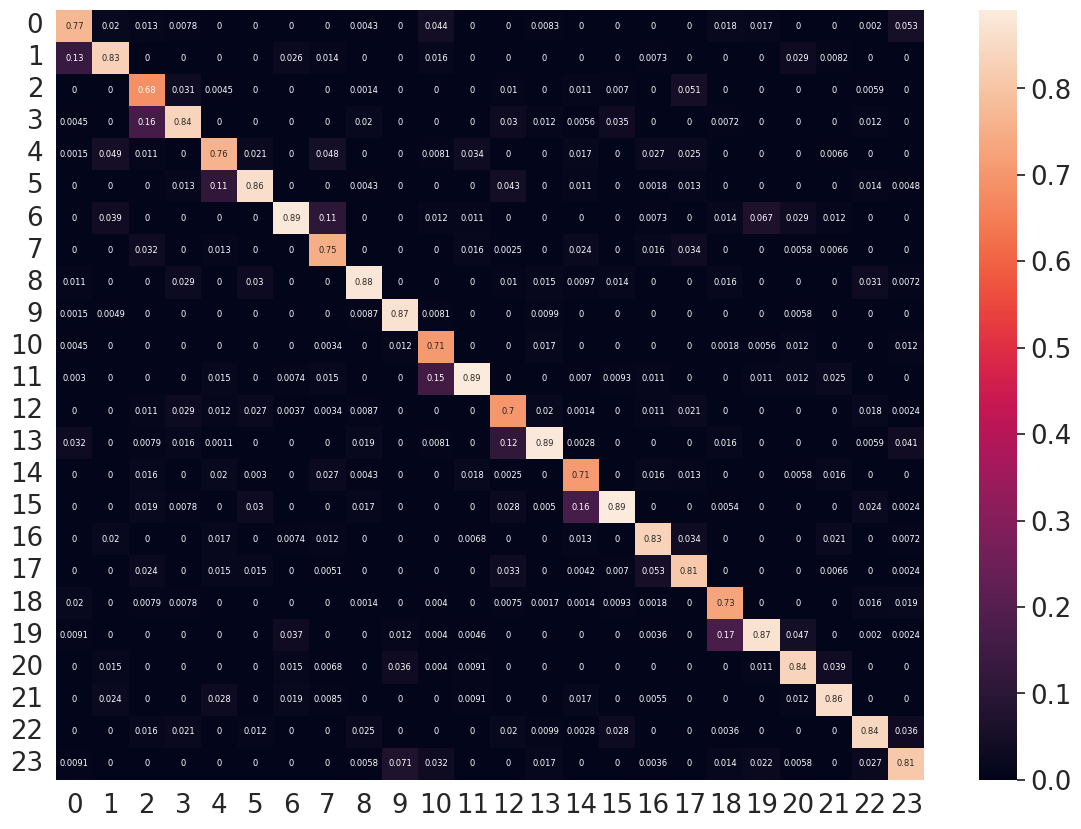

In [16]:
import seaborn as sn
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(result, range(24), range(24))
plt.figure(figsize=(14,10))
sn.set(font_scale=1.7) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 6}) # font size

plt.show()

In [12]:
# Implement an HMM??
!pip install hmmlearn

import numpy as np
from hmmlearn import hmm
from sklearn.preprocessing import OneHotEncoder
from collections import Counter

def extract_features(midi_notes):
    """
    Convert a list of MIDI notes to a feature vector.
    Uses pitch class profile (chroma) representation.
    """
    # Initialize a 12-element vector for the 12 pitch classes (C, C#, D, etc.)
    pitch_class_profile = np.zeros(12)
    
    # Count occurrences of each pitch class
    for note in midi_notes:
        pitch_class = note % 12  # Convert MIDI note to pitch class (0-11)
        pitch_class_profile[pitch_class] += 1
    
    # Normalize the vector
    if np.sum(pitch_class_profile) > 0:
        pitch_class_profile = pitch_class_profile / np.sum(pitch_class_profile)
    
    return pitch_class_profile

def prepare_data(data):
    """
    Convert the raw data into features and labels.
    """
    X = []  # Features
    y = []  # Labels (chord identifiers)
    
    for midi_notes, chord_label in data:
        features = extract_features(midi_notes)
        X.append(features)
        y.append(chord_label)
    
    return np.array(X), np.array(y)

def train_hmm_model(X, unique_chord_labels):
    """
    Train an HMM model.
    """
    n_chords = len(unique_chord_labels)
    model = hmm.GaussianHMM(n_components=n_chords, covariance_type="full", n_iter=10000)
    
    # Train the model
    model.fit(X)
    
    return model

def predict_chords(model, X, chord_mapping):
    """
    Predict chords using the trained HMM.
    """
    # Predict state sequence
    state_sequence = model.predict(X)
    
    # Convert state indices to chord labels
    predicted_chords = [chord_mapping[state] for state in state_sequence]
    
    return predicted_chords

# Example usage
train_data = all_data[0:70]
flattened_data = [pair for song in train_data for pair in song]
raw_data = [(midi_notes, chord_label) for midi_notes, chord_label in flattened_data]
X, y = prepare_data(raw_data)

# Get unique chord labels and create a mapping
unique_chord_labels = np.unique(y)
chord_to_state = {chord: idx for idx, chord in enumerate(unique_chord_labels)}
state_to_chord = {idx: chord for idx, chord in enumerate(unique_chord_labels)}

# Train the model
model = train_hmm_model(X, unique_chord_labels)

# Predict chords
predicted_chords = predict_chords(model, X, state_to_chord)

In [15]:
from sklearn.metrics import accuracy_score

def evaluate_sequences(sequences, model, chord_mapping):
    """Evaluate model on complete musical sequences"""
    sequence_accuracies = []
    
    for sequence in sequences:
        X_seq, y_seq = prepare_data(sequence)
        predictions = predict_chords(model, X_seq, chord_mapping)
        accuracy = accuracy_score(y_seq, predictions)
        sequence_accuracies.append(accuracy)
    
    return np.mean(sequence_accuracies)

test_data = all_data[70:100]
evaluate_sequences(test_data, model, state_to_chord)

0.06247933294019934